Make the notebook wider (if you think this makes the notebook look prettier)

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Import the library with all predefine functions

In [2]:
import lazy_pipeline as lpipe

Check library versions

In [3]:
from platform import python_version
import sklearn
print(python_version())
print(lpipe.pd.__version__)
print(sklearn.__version__)

3.9.12
1.5.2
1.1.3


Run seamlessly on 
* python = 3.9.13, 
* pandas = 1.5.1
* scikit-learn = 1.1.3

# Prepare tic tac toe the data

Load data

In [4]:
df = lpipe.load_data('tic_tac_toe')
print(df.shape)
df.head()

(958, 10)


,top-left-square,top-middle-square,top-right-square,middle-left-square,middle-middle-square,middle-right-square,bottom-left-square,bottom-middle-square,bottom-right-square,Class
0,x,x,x,x,o,o,x,o,o,True
1,x,x,x,x,o,o,o,x,o,True
2,x,x,x,x,o,o,o,o,x,True
3,x,x,x,x,o,o,o,b,b,True
4,x,x,x,x,o,o,b,o,b,True


Binarize data

In [5]:
y_name = 'Class'

In [6]:
y = df[y_name]
X = lpipe.binarize_X(df.drop(y_name, axis=1))
print(X.shape)
X.head()

(958, 27)


,top-left-square: b,top-left-square: o,top-left-square: x,top-middle-square: b,top-middle-square: o,top-middle-square: x,top-right-square: b,top-right-square: o,top-right-square: x,middle-left-square: b,...,middle-right-square: x,bottom-left-square: b,bottom-left-square: o,bottom-left-square: x,bottom-middle-square: b,bottom-middle-square: o,bottom-middle-square: x,bottom-right-square: b,bottom-right-square: o,bottom-right-square: x
0,False,False,True,False,False,True,False,False,True,False,...,False,False,False,True,False,True,False,False,True,False
1,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,False,True,False,True,False
2,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,True,False,False,False,True
3,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,True,False,False,True,False,False
4,False,False,True,False,False,True,False,False,True,False,...,False,True,False,False,False,True,False,True,False,False


Shuffle the data to drop any initial ordering of rows. For example, if the dataset is constructed first from all positive examples and then all negative examples.

_NB: Skip this step if your data is sequential and rows ordering is important. For example, if your dataset contains a "date" feature._

In [7]:
X = X.sample(frac=1, random_state=42)  # Shuffle X
y = y[X.index]  # Order y to follow the order of rows from X

Represent data $X$ as list of subsets of attributes to better suit the theory.

In [8]:
X_bin = [set(X.columns[x]) for idx, x in X.iterrows()]
X_bin[0]

{'bottom-left-square: x',
 'bottom-middle-square: o',
 'bottom-right-square: x',
 'middle-left-square: b',
 'middle-middle-square: x',
 'middle-right-square: x',
 'top-left-square: o',
 'top-middle-square: o',
 'top-right-square: o'}

And, for being consisted, convert $y$ to list too.

In [9]:
y_list = y.values.tolist()

Assume that at the very begining, we know the labels only for the first 20% of rows.

In [10]:
n_train = int(len(X)*0.1)
n_test = len(X) - n_train
n_train, n_test

(95, 863)

Set up the test target labels $y$

In [11]:
y_test = y_list[n_train:]

# Make predictions for base algorithm

Make predictions and measure time required to obtain these predictions

In [12]:
%%time
gen = lpipe.predict_array(X_bin, y_list, n_train, use_tqdm=True)
y_preds, t_preds = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 958/958 [00:16<00:00, 53.53it/s] 

CPU times: user 16 s, sys: 163 ms, total: 16.2 s
Wall time: 16.1 s


In [13]:
%%time
gen = lpipe.predict_array(X_bin, y_list, n_train, use_tqdm=True, update_train=False)
y_preds_fixedtrain, t_preds_fixedtrain = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 958/958 [00:00<00:00, 1642.42it/s]

CPU times: user 524 ms, sys: 5.89 ms, total: 530 ms
Wall time: 528 ms


Evaluate predictions

Here we decided to measure Accuracy and F1 score simply because there ones of the most popular scores. Feel free to use more elaborate scorings.

In [14]:
from sklearn.metrics import accuracy_score, f1_score

score_vals = {}
for score_f in [accuracy_score, f1_score]:
    score_name = score_f.__name__
    preds = y_preds
    score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]

    score_name = score_f.__name__ + '_fixedtrain'
    preds = y_preds_fixedtrain
    score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]

# Make prediction for new algorithm

First a bit differently prepare data, because I use pattern structures and don't need binarization. We will keep same amount of train and test data for fair comparition of algorithms.

In [15]:
from sklearn.model_selection import train_test_split
y = df[y_name]
X = df.drop(y_name, axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.9, 
    shuffle=True, 
    stratify=y, 
    random_state=42)

In [16]:
%%time
from lazy_fca_estimator import LazyFCA

fca = LazyFCA(
    consistency_threshold=0.8,
    undefined_treshhold=0.8,
    min_extent_size=2,
    check_number=1,
    update_train=False
)

prediction, t_preds_new = lpipe.apply_stopwatch(fca.predict(X_test, X_train, y_train, generator=True))

CPU times: user 690 ms, sys: 3.78 ms, total: 694 ms
Wall time: 693 ms


In [17]:
from undefine_scores import f1_undefine_score, accuracy_undefine_score

preds = prediction
score_vals['accuracy_score_new'] = [accuracy_undefine_score(y_test[:i], preds[:i]) for i in range(1, len(preds))]
preds = prediction
score_vals['f1_score_new'] = [f1_undefine_score(y_test[:i], preds[:i], pos_label=True) for i in range(1, len(preds))]

/var/folders/8q/sgl781rj2dx5hblndkkmhd340000gn/T/ipykernel_15017/890214397.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  score_vals['accuracy_score_new'] = [accuracy_undefine_score(y_test[:i], preds[:i]) for i in range(1, len(preds))]
/var/folders/8q/sgl781rj2dx5hblndkkmhd340000gn/T/ipykernel_15017/890214397.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  score_vals['accuracy_score_new'] = [accuracy_undefine_score(y_test[:i], preds[:i]) for i in range(1, len(preds))]
/v

# Analyze results

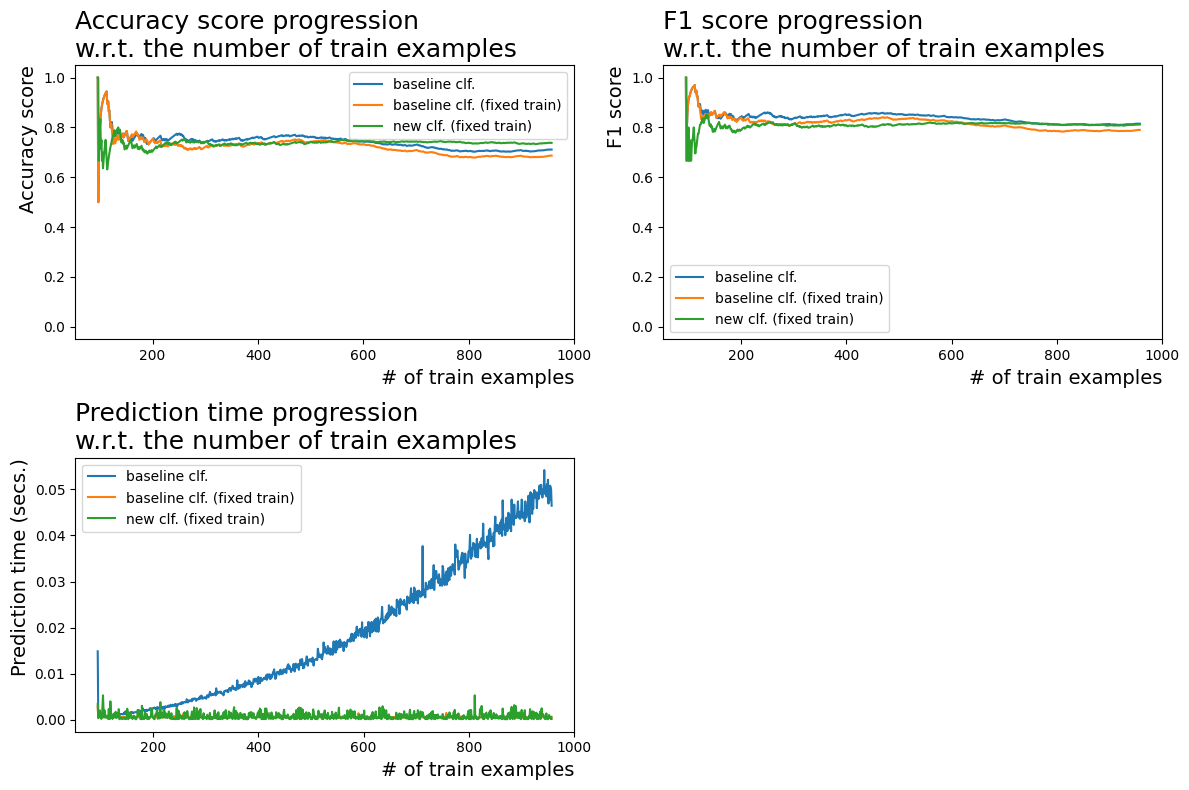

In [18]:
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = (1,1,1,1)  # Replace default "transparent" background of the figure with the "white" one


fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# First two plots are for prediction quality comparison
for ax, t in zip(axs[0],['accuracy_score', 'f1_score']):
    ax.set_ylim(0-0.05, 1+0.05)
    ax.plot(range(n_train+1, len(X)), score_vals[t], label='baseline clf.')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_fixedtrain'], label='baseline clf. (fixed train)')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_new'], label='new clf. (fixed train)')
    
# The third plot is for prediction speed comparison
axs[1,0].plot(range(n_train, len(X)), t_preds, label='baseline clf.')
axs[1,0].plot(range(n_train, len(X)), t_preds_fixedtrain, label='baseline clf. (fixed train)')
axs[1,0].plot(range(n_train, len(X)), t_preds_new, label='new clf. (fixed train)')

# Add labels and titles to the plots
for (ax, t_verb, dim) in zip(axs.flatten(), ['Accuracy score', 'F1 score', 'Prediction time'], ['','','(secs.)']):
    ax.set_title('\n'.join([f"{t_verb} progression", "w.r.t. the number of train examples"]), loc='left', size=18)
    ax.set_xlabel('# of train examples', loc='right', size=14)
    ax.set_ylabel(f"{t_verb} {dim}".strip(), loc='top', size=14)
    ax.legend()
    
# Drop the predefined fourth plot since we do not use it
axs[1,1].set_axis_off()    

# Some postprocessing of plots
plt.tight_layout()
plt.subplots_adjust()

plt.savefig('image/Classifier_comparison.png')
plt.show()

# In conclusion:
New algorithm has slitly better accuracy and aproximetly similar f1 score and time comparitions. But pattern structures work much better with bigger data so let's compare algorithms on 10% for train and 90% for train.

In [19]:
n_train = int(len(X)*0.9)
n_test = len(X) - n_train
n_train, n_test

(862, 96)

In [20]:
%%time
gen = lpipe.predict_array(X_bin, y_list, n_train, use_tqdm=True)
y_preds, t_preds = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 958/958 [00:04<00:00, 21.03it/s]

CPU times: user 4.53 s, sys: 44 ms, total: 4.57 s
Wall time: 4.57 s


In [21]:
%%time
gen = lpipe.predict_array(X_bin, y_list, n_train, use_tqdm=True, update_train=False)
y_preds_fixedtrain, t_preds_fixedtrain = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|██████████| 958/958 [00:04<00:00, 23.64it/s]

CPU times: user 4.02 s, sys: 42.8 ms, total: 4.07 s
Wall time: 4.06 s


In [22]:
from sklearn.metrics import accuracy_score, f1_score

score_vals = {}
for score_f in [accuracy_score, f1_score]:
    score_name = score_f.__name__
    preds = y_preds
    score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]

    score_name = score_f.__name__ + '_fixedtrain'
    preds = y_preds_fixedtrain
    score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]

/var/folders/8q/sgl781rj2dx5hblndkkmhd340000gn/T/ipykernel_15017/2919180408.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
/var/folders/8q/sgl781rj2dx5hblndkkmhd340000gn/T/ipykernel_15017/2919180408.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
/var/folders/8q/sgl781rj2dx5hblndkkmhd340000gn/T/ipy

In [23]:
from sklearn.model_selection import train_test_split
y = df[y_name]
X = df.drop(y_name, axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.1, 
    shuffle=True, 
    stratify=y, 
    random_state=42)

In [24]:
%%time
from lazy_fca_estimator import LazyFCA

fca = LazyFCA(
    consistency_threshold=0.9,
    undefined_treshhold=0.9,
    min_extent_size=3,
    check_number=1,
    update_train=True
)

prediction, t_preds_new = lpipe.apply_stopwatch(fca.predict(X_test, X_train, y_train))

CPU times: user 1.64 s, sys: 5.86 ms, total: 1.65 s
Wall time: 1.65 s


In [25]:
from undefine_scores import f1_undefine_score, accuracy_undefine_score

preds = prediction
score_vals['accuracy_score_new'] = [accuracy_undefine_score(y_test[:i], preds[:i]) for i in range(1, len(preds))]
preds = prediction
score_vals['f1_score_new'] = [f1_undefine_score(y_test[:i], preds[:i], pos_label=True) for i in range(1, len(preds))]

/var/folders/8q/sgl781rj2dx5hblndkkmhd340000gn/T/ipykernel_15017/890214397.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  score_vals['accuracy_score_new'] = [accuracy_undefine_score(y_test[:i], preds[:i]) for i in range(1, len(preds))]
/var/folders/8q/sgl781rj2dx5hblndkkmhd340000gn/T/ipykernel_15017/890214397.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  score_vals['accuracy_score_new'] = [accuracy_undefine_score(y_test[:i], preds[:i]) for i in range(1, len(preds))]
/v

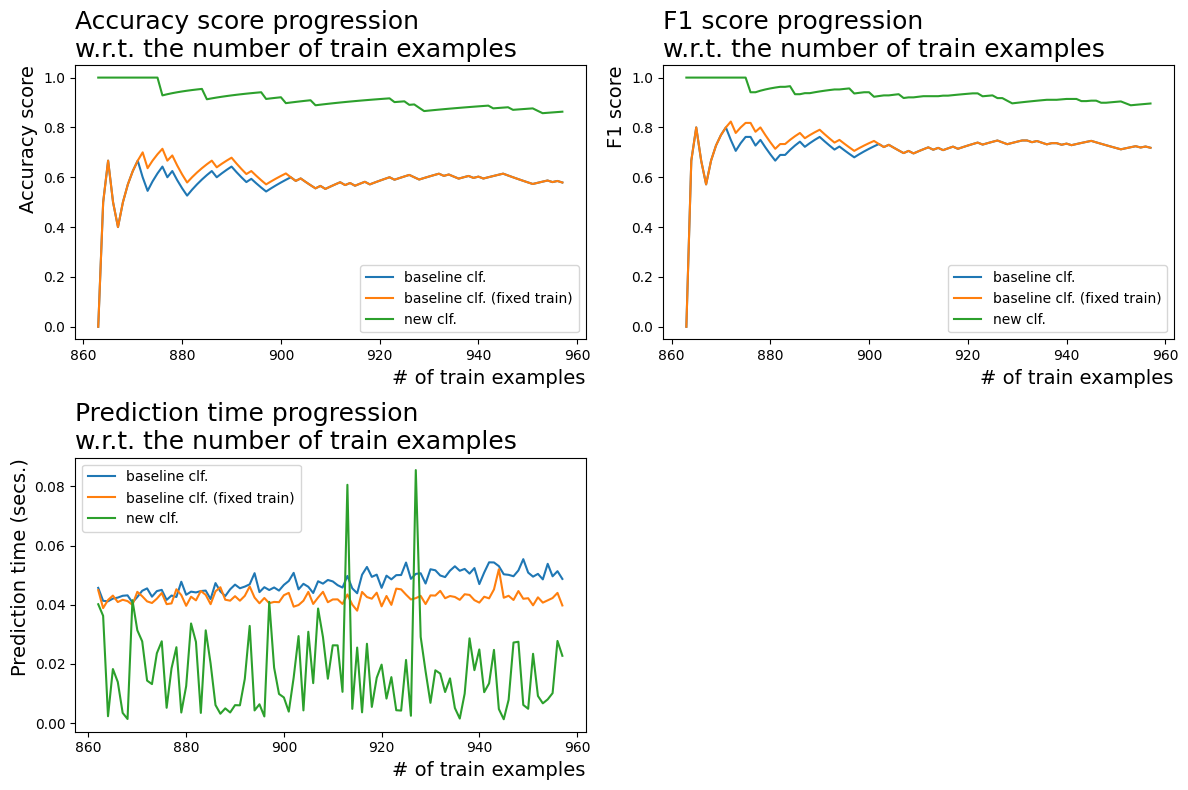

In [27]:
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = (1,1,1,1)  # Replace default "transparent" background of the figure with the "white" one


fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# First two plots are for prediction quality comparison
for ax, t in zip(axs[0],['accuracy_score', 'f1_score']):
    ax.set_ylim(0-0.05, 1+0.05)
    ax.plot(range(n_train+1, len(X)), score_vals[t], label='baseline clf.')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_fixedtrain'], label='baseline clf. (fixed train)')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_new'], label='new clf.')
    
# The third plot is for prediction speed comparison
axs[1,0].plot(range(n_train, len(X)), t_preds, label='baseline clf.')
axs[1,0].plot(range(n_train, len(X)), t_preds_fixedtrain, label='baseline clf. (fixed train)')
axs[1,0].plot(range(n_train, len(X)), t_preds_new, label='new clf.')

# Add labels and titles to the plots
for (ax, t_verb, dim) in zip(axs.flatten(), ['Accuracy score', 'F1 score', 'Prediction time'], ['','','(secs.)']):
    ax.set_title('\n'.join([f"{t_verb} progression", "w.r.t. the number of train examples"]), loc='left', size=18)
    ax.set_xlabel('# of train examples', loc='right', size=14)
    ax.set_ylabel(f"{t_verb} {dim}".strip(), loc='top', size=14)
    ax.legend()
    
# Drop the predefined fourth plot since we do not use it
axs[1,1].set_axis_off()    

# Some postprocessing of plots
plt.tight_layout()
plt.subplots_adjust()

plt.savefig('image/Classifier_comparison_bigger_data.png')
plt.show()

# Conclusion for bigger data
For bigger train data new algorithem show much better results. Time for classification can be slitly different because it depend on number of appropriate extents thet we can find.